In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator


In [2]:
def nencioli(u, v, lon, lat, a, b):
    """
    Identify the points in the domain which satisfy the four velocity constraints for eddy detection.

    Parameters:
    - u, v: 2D velocity fields for u and v components
    - lon, lat: Longitude and Latitude matrices
    - mask: Matrix defining sea (1) and land points (0)
    - a, b: Parameters used for constraints

    Returns:
    - eddy_uv: Positions that satisfy the first two constraints (for debugging)
    - eddy_c: Positions satisfying the first three constraints (for debugging)
    - eddy: Positions of the eddy centers with their type (cyclonic=1, anticyclonic=-1) (opposite for me)
    """

    borders = max(a, b) + 1

    # Compute velocity magnitude
    vel = np.sqrt(u**2 + v**2)

    # Initialize arrays for storing eddy centers
    eddy_uv = np.zeros((0, 2))
    eddy_c = np.zeros((0, 2))
    eddy = np.zeros((0, 3))

    # Get domain dimensions
    bound = vel.shape

    # Loop through each latitudinal section
    for i in range(borders, len(v) - borders + 1):
        wrk = v[i, :]  # Latitudinal section of v

        # First constraint: zero crossing in v component
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        indx = indx[(indx >= borders) & (indx < len(wrk) - borders)]

        for ii in indx:
            var = 0  # Eddy type (0 = no eddy, 1 = cyclonic, -1 = anticyclonic)
            if wrk[ii] >= 0:  # Anticyclonic
                if wrk[ii - a] > wrk[ii] and wrk[ii + 1 + a] < wrk[ii + 1]:
                    var = -1
            elif wrk[ii] < 0:  # Cyclonic
                if wrk[ii - a] < wrk[ii] and wrk[ii + 1 + a] > wrk[ii + 1]:
                    var = 1

            # Second constraint: u component reversal
            if var != 0:
                if var == -1:
                    if (u[i - a, ii] <= 0 and u[i - a, ii] <= u[i - 1, ii] and
                        u[i + a, ii] >= 0 and u[i + a, ii] >= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0
                elif var == 1:
                    if (u[i - a, ii] >= 0 and u[i - a, ii] >= u[i - 1, ii] and
                        u[i + a, ii] <= 0 and u[i + a, ii] <= u[i + 1, ii]):
                        eddy_uv = np.vstack([eddy_uv, [lat[i, ii], lon[i, ii]], [lat[i, ii + 1], lon[i, ii + 1]]])
                    else:
                        var = 0

                # Third constraint: velocity minimum
                if var != 0:
                    srch = vel[i - b:i + b, ii - b:ii + b + 1]
                    slat = lat[i - b:i + b, ii - b:ii + b + 1]
                    slon = lon[i - b:i + b, ii - b:ii + b + 1]
                    X, Y = np.unravel_index(np.argmin(srch), srch.shape)
                    srch2 = vel[max(i - b + X - 1 - b, 0):min(i - b + X - 1 + b, bound[0]),
                                max(ii - b + Y - 1 - b, 0):min(ii - b + Y - 1 + b, bound[1])]

                    if np.min(srch2) == np.min(srch):
                        eddy_c = np.vstack([eddy_c, [slat[X, Y], slon[X, Y]]])
                    else:
                        var = 0

                # Fourth constraint: vector rotation (simplified version)
                d = a - 1
                if var != 0:
                    # Find indices of the estimated center in the large domain
                    i1, i2 = np.where((lat == slat[X, Y]) & (lon == slon[X, Y]))

                    i1, i2 = int(i1[0]), int(i2[0])
                    
                    # Extract velocities within "a-1" points from the estimated center
                    u_small = u[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    v_small = v[max(i1 - d, 0):min(i1 + d, bound[0]), max(i2 - d, 0):min(i2 + d, bound[1])]
                    
                    # Apply constraint only if there are no NaNs in u_small
                    if not np.isnan(u_small).any():
                        # Boundary velocities
                        u_bound = np.concatenate([u_small[0, :], u_small[1:, -1], u_small[-1, -2::-1], u_small[-2::-1, 0]])
                        v_bound = np.concatenate([v_small[0, :], v_small[1:, -1], v_small[-1, -2::-1], v_small[-2::-1, 0]])

                        # Vector defining which quadrant each boundary vector belongs to
                        quadrants = np.zeros_like(u_bound)
                        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
                        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
                        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
                        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4
                        
                        # Identify the first fourth quadrant vector
                        spin = np.where(quadrants == 4)[0]
                        
                        # Apply the constraint only if the rotation is complete and not all vectors are in the fourth quadrant
                        if spin.size > 0 and spin.size != quadrants.size:
                            # If vectors start in the 4th quadrant, add 4 to all quadrant positions after the first occurrence
                            if spin[0] == 0:
                                spin = np.where(quadrants != 4)[0]
                                spin = spin[0] - 1
                                
                            if not isinstance(spin, np.ndarray):
                                spin = np.array([int(spin)])
                            quadrants[spin[-1] + 1:] += 4
                            
                            # Inspect vector rotation: no consecutive vectors should be more than one quadrant apart
                            # and there should be no backward rotation
                            if not np.any(np.diff(quadrants) > 1) and not np.any(np.diff(quadrants) < 0):
                                eddy = np.vstack([eddy, [slat[X, Y], slon[X, Y], var]])


    # Process eddy results (sorting and removing duplicates)
    eddy = np.unique(eddy, axis=0)
    eddy_uv = np.unique(eddy_uv, axis=0)
    eddy_c = np.unique(eddy_c, axis=0)
    # Adjust for the Southern Hemisphere (flip cyclonic/anticyclonic labels)
    # eddy[eddy[:, 0] < 0, 2] = -eddy[eddy[:, 0] < 0, 2]
    eddy[:, 2] = -eddy[:, 2]
    # Swap for personal preference 
    eddy[:, [0, 1]] = eddy[:, [1, 0]]

    return eddy_uv, eddy_c, eddy

def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):

        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
            
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse


#### Getting the grid

In [3]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))



In [4]:
def interpolate_uv(u, v, x_grid, y_grid, X_new, Y_new, angle):
    u_east = np.where(u > 1e30, np.nan, u).astype(float)
    v_north = np.where(v > 1e30, np.nan, v).astype(float)

    u_rot = v_north * np.sin(angle) + u_east * np.cos(angle)
    v_rot = v_north * np.cos(angle) - u_east * np.sin(angle)

    shape_new = X_new.shape
    new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

    interp_u = RegularGridInterpolator((x_grid, y_grid), u_rot,
                                       method='linear', bounds_error=False, fill_value=np.nan)
    interp_v = RegularGridInterpolator((x_grid, y_grid), v_rot,
                                       method='linear', bounds_error=False, fill_value=np.nan)

    u_new = interp_u(new_points).reshape(shape_new)
    v_new = interp_v(new_points).reshape(shape_new)

    return u_new, v_new

ROMS_velocity_dic = {}
for day in range(1462, 1462 + 151):
    fnumber = 1461 + ((day - 1462) // 30)*30
    fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnumber:05}.nc'
    dataset = nc.Dataset(fname)
    u_east = np.transpose(dataset['u_eastward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
    v_north = np.transpose(dataset['v_northward'][:].data, axes=(3, 2, 1, 0))[:, :, -1, :].squeeze()
    ocean_time = dataset.variables['ocean_time'][:].data / 86400
    t = np.where(day==ocean_time)[0][0]
    u, v = u_east[:, :, t], v_north[:, :, t]
    u_new, v_new = interpolate_uv(u, v, x_grid, y_grid, X_new, Y_new, angle)
    ROMS_velocity_dic[day] = {}
    ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v'] = u_new, v_new


In [5]:
rows = []
for day in ROMS_velocity_dic.keys():
    u0, v0 = ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v']

    # nencioli returns a tuple; use index 2 for neddy
    neddy = nencioli(u0.T, v0.T, X_new.T, Y_new.T, 4, 3)[2]
    # sort so that the highest 'neddy' second column comes first
    neddy = neddy[neddy[:, 1].argsort()[::-1]]
    
    # Loop over each eddy in this day
    for idx, eddy_vals in enumerate(neddy):
        nxc0, nyc0, cyc_indicator = eddy_vals  # assuming 3 columns: x-coordinate, y-coordinate, and a cycle indicator
        cyc_value = 'CE' if cyc_indicator == 1 else 'AE'
        
        # Find indices in the original grid corresponding to the eddy location
        nic_idx, njc_idx = np.where((X_new == nxc0) & (Y_new == nyc0))
        if len(nic_idx) > 0:
            nic0, njc0 = nic_idx[0], njc_idx[0]
        else:
            nic0, njc0 = np.nan, np.nan
        
        # Get the corresponding lon/lat values
        nlon_val = lon_new[nic0, njc0]
        nlat_val = lat_new[nic0, njc0]
        
        # Append a row for this eddy
        rows.append({
            'Eddy': idx,
            'Day': day,
            'Cyc': cyc_value,
            'nLon': nlon_val,
            'nLat': nlat_val,
            'nxc': nxc0,
            'nyc': nyc0,
            'nic': nic0,
            'njc': njc0
        })

# Create the DataFrame from the list of dictionaries
df_nenc = pd.DataFrame(rows)
df_nenc

,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285
...,...,...,...,...,...,...,...,...,...
5843,47,1612,CE,151.896614,-38.964668,410.0,93.0,410,93
5844,48,1612,AE,152.974063,-39.278422,509.0,92.0,509,92
5845,49,1612,CE,154.440314,-39.803811,646.0,80.0,646,80
5846,50,1612,CE,153.077008,-39.421593,522.0,80.0,522,80


(np.float64(147.0258764350329),
 np.float64(162.1969341673239),
 np.float64(-41.5791631412529),
 np.float64(-25.074123716396034))

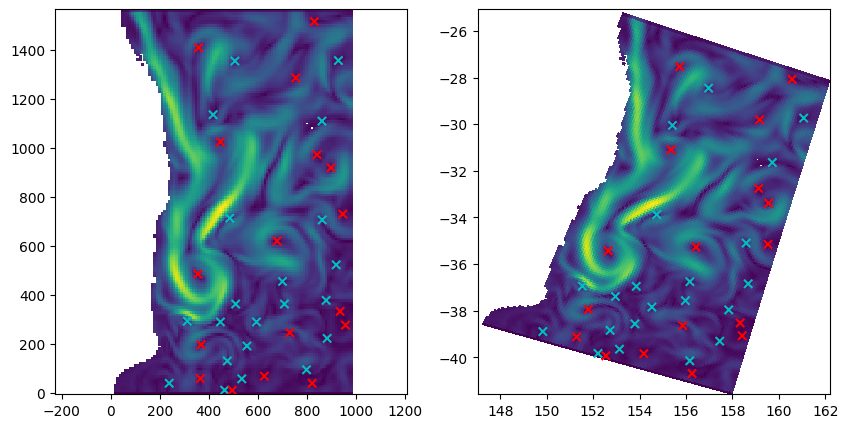

In [6]:
t = 0

day = list(ROMS_velocity_dic.keys())[t]
u0, v0 = ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v']

fig, axs = plt.subplots(1, 2, figsize=(10,5))

spacing = 10
axs[0].pcolor(X_new[::spacing, ::spacing], Y_new[::spacing, ::spacing], np.hypot(u0[::spacing, ::spacing], v0[::spacing, ::spacing]))

df_day = df_nenc[df_nenc['Day']==day].copy()
df_day['color'] = np.where(df_day['Cyc'] == 'AE', 'r', 'c')
axs[0].scatter(df_day['nxc'], df_day['nyc'], color=df_day['color'], marker='x')
axs[0].axis('equal')

axs[1].pcolor(lon_new[::spacing, ::spacing], lat_new[::spacing, ::spacing], np.hypot(u0[::spacing, ::spacing], v0[::spacing, ::spacing]))
axs[1].scatter(df_day['nLon'], df_day['nLat'], color=df_day['color'], marker='x')
axs[1].axis('equal')

In [7]:
def espra(xi, yi, ui, vi):

    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.array([[np.nan, np.nan], [np.nan, np.nan]]), np.nan
    
    from scipy.optimize import least_squares

    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])

    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 

    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)

    w = 2*(q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])
    
    return x0, y0, Q, w

In [8]:
df_data = df_nenc.copy()

for day in df_data['Day'].unique():
    df_day = df_data[df_data['Day'] == day].copy()
    for e in df_day['Eddy'].unique():
        df_eddy = df_day[df_day['Eddy'] == e].copy()
        # Assuming one row per eddy; if there are multiple rows, adjust as needed.
        nxc = df_eddy['nxc'].iloc[0]
        nyc = df_eddy['nyc'].iloc[0]

        mask = np.hypot(nxc - X_new, nyc - Y_new) <= 30

        ut, vt = ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v']
        ui, vi = ut[mask], vt[mask]
        xi, yi = X_new[mask], Y_new[mask]

        if np.any(np.isnan(ui)):
            mask = np.hypot(nxc - X_new, nyc - Y_new) <= 20

            ut, vt = ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v']
            ui, vi = ut[mask], vt[mask]
            xi, yi = X_new[mask], Y_new[mask]

        if np.any(np.isnan(ui)):
            mask = np.hypot(nxc - X_new, nyc - Y_new) <= 10

            ut, vt = ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v']
            ui, vi = ut[mask], vt[mask]
            xi, yi = X_new[mask], Y_new[mask]
            
        # Compute the output values using your function.
        x0, y0, Q, w = espra(xi, yi, ui, vi)

        if np.hypot(nxc - x0, nyc - y0) > 50:
            x0, y0, Q, w = np.nan, np.nan, np.array([[np.nan, np.nan], [np.nan, np.nan]]), np.nan 

        # Update the main DataFrame using .loc to avoid chained indexing.
        update_mask = (df_data['Day'] == day) & (df_data['Eddy'] == e)
        df_data.loc[update_mask, 'x0'] = x0
        df_data.loc[update_mask, 'y0'] = y0
        df_data.loc[update_mask, 'q11'] = Q[0,0]
        df_data.loc[update_mask, 'q12'] = Q[1,0]
        df_data.loc[update_mask, 'q22'] = Q[1,1]
        df_data.loc[update_mask, 'w'] = w

df_data

,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,x0,y0,q11,q12,q22,w
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,836.867917,1520.899658,0.003011,-0.000090,0.005076,0.016174
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.723030,1404.524061,0.007987,-0.002294,0.005803,0.027581
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,510.292455,1353.033146,-0.008094,0.001176,-0.006943,-0.030074
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,752.203674,1287.290040,0.005505,-0.001515,0.003850,0.018711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,47,1612,CE,151.896614,-38.964668,410.0,93.0,410,93,417.237194,87.191563,-0.002619,0.000554,-0.001651,-0.008539
5844,48,1612,AE,152.974063,-39.278422,509.0,92.0,509,92,506.194216,82.454157,0.000180,-0.000450,0.000256,0.000873
5845,49,1612,CE,154.440314,-39.803811,646.0,80.0,646,80,659.870740,67.595859,-0.000737,-0.000518,-0.001348,-0.004170
5846,50,1612,CE,153.077008,-39.421593,522.0,80.0,522,80,509.374612,85.176869,0.000152,0.000076,-0.001678,-0.003051


,Eddy,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,x0,y0,q11,q12,q22,w
0,0,1462,AE,160.569072,-28.075269,830.0,1515.0,830,1515,836.867917,1520.899658,0.003011,-0.000090,0.005076,0.016174
1,1,1462,AE,155.725082,-27.535036,358.0,1408.0,358,1408,357.723030,1404.524061,0.007987,-0.002294,0.005803,0.027581
2,2,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293
3,3,1462,CE,156.973832,-28.452969,506.0,1354.0,506,1354,510.292455,1353.033146,-0.008094,0.001176,-0.006943,-0.030074
4,4,1462,AE,159.170505,-29.807511,754.0,1285.0,754,1285,752.203674,1287.290040,0.005505,-0.001515,0.003850,0.018711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,47,1612,CE,151.896614,-38.964668,410.0,93.0,410,93,417.237194,87.191563,-0.002619,0.000554,-0.001651,-0.008539
5844,48,1612,AE,152.974063,-39.278422,509.0,92.0,509,92,506.194216,82.454157,0.000180,-0.000450,0.000256,0.000873
5845,49,1612,CE,154.440314,-39.803811,646.0,80.0,646,80,659.870740,67.595859,-0.000737,-0.000518,-0.001348,-0.004170
5846,50,1612,CE,153.077008,-39.421593,522.0,80.0,522,80,509.374612,85.176869,0.000152,0.000076,-0.001678,-0.003051


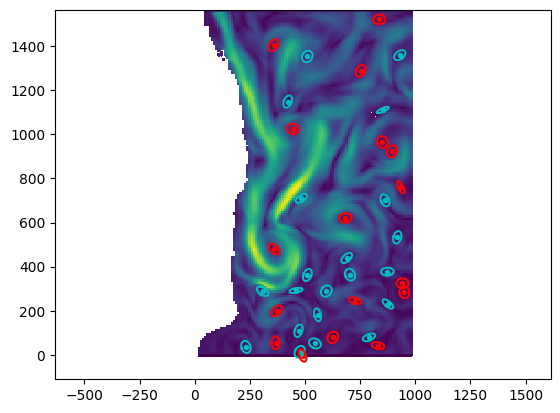

In [9]:
t = 0

day = list(ROMS_velocity_dic.keys())[t]
u0, v0 = ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v']

spacing = 10
plt.pcolor(X_new[::spacing, ::spacing], Y_new[::spacing, ::spacing], np.hypot(u0[::spacing, ::spacing], v0[::spacing, ::spacing]))

df_day = df_data[df_data['Day']==day].copy()

for e in df_day['Eddy'].unique():
    flag = 0

    df_eddy = df_day[df_day['Eddy']==e].copy()

    x0, y0, q11, q12, q22 = df_eddy['x0'].iloc[0], df_eddy['y0'].iloc[0], df_eddy['q11'].iloc[0], df_eddy['q12'].iloc[0], df_eddy['q22'].iloc[0]

    if np.isnan(q11):
        print(e)

    if np.isnan(x0):
        x0, y0 = df_eddy['nxc'].iloc[0], df_eddy['nyc'].iloc[0]
        flag = 1
    
    c = 'r' if df_eddy['Cyc'].iloc[0] == 'AE' else 'c'
    marker = 'x' if flag else '.'
    plt.scatter(x0, y0, color=c, marker=marker)

    Q = np.array([[q11, q12], [q12, q22]])
    x_ellipse, y_ellipse = plot_ellipse(Q, (x0, y0), scale=30)
    plt.plot(x_ellipse, y_ellipse, color=c)

plt.axis('equal')
df_data

In [10]:
# Initialize ID values
df_data['ID'] = -1
df_data.loc[df_data['Day'] == df_data['Day'].min(), 'ID'] = df_data.loc[df_data['Day'] == df_data['Day'].min(), 'Eddy']
df_data['ID'] = df_data['ID'].astype('Int64')
next_num = df_data['ID'].max() + 1

R_df = pd.DataFrame(columns=['D_diff', 'W_diff', 'R'])
# Loop through days starting from 1 (since day 0 is already assigned)
for day in range(df_data['Day'].min()+1, df_data['Day'].max() + 1):
    
    # Get present day data (filtering out rows with NaN in 'x0')
    pres_day = df_data.loc[df_data['Day'] == day].copy()
    pres_day = pres_day[~np.isnan(pres_day['x0'])]
    
    VORT_WEIGHT = 15000
    R_THRESH = 30
    
    # Loop over each unique eddy in the present day
    for e_pres in pres_day['Eddy'].unique():
        pres_eddy = pres_day.loc[pres_day['Eddy'] == e_pres].iloc[0]
        assigned = False  # flag to indicate whether an ID was assigned
        
        # Look back up to 4 days
        for delta in range(1, 5):
            candidate_day = day - delta
            if candidate_day < 0:
                continue  # skip if candidate_day becomes negative
            
            candidate_prev_day = df_data.loc[df_data['Day'] == candidate_day].copy()
            candidate_prev_day = candidate_prev_day[~np.isnan(candidate_prev_day['x0'])]
            
            # Loop over each unique eddy in the candidate previous day
            for e_prev in candidate_prev_day['Eddy'].unique():
                prev_eddy = candidate_prev_day.loc[candidate_prev_day['Eddy'] == e_prev].iloc[0]
                R = np.sqrt(
                    (pres_eddy['x0'] - prev_eddy['x0'])**2 +
                    (pres_eddy['y0'] - prev_eddy['y0'])**2 +
                    VORT_WEIGHT * (pres_eddy['w'] - prev_eddy['w'])**2
                )
                R_df.loc[len(R_df)] = {'D_diff': np.hypot(pres_eddy['x0'] - prev_eddy['x0'], pres_eddy['y0'] - prev_eddy['y0']), 'W_diff': np.abs(pres_eddy['w'] - prev_eddy['w']), 'R': R}
                # Check conditions: distance below threshold, cycle types match,
                # and the previous eddy's ID is not already assigned to any eddy in the present day.
                if R < R_THRESH and (pres_eddy['Cyc'] == prev_eddy['Cyc']) and not (pres_day['ID'] == prev_eddy['ID']).any():
                    
                    df_data.loc[(df_data['Day'] == day) & (df_data['Eddy'] == e_pres), 'ID'] = prev_eddy['ID']
                    assigned = True
                    break  # found a match; break out of candidate previous day's loop
            if assigned:
                break  # break out of the look-back loop if a match was found
        
        # If no match was found in any of the past 4 days, assign a new ID
        if not assigned:
            df_data.loc[(df_data['Day'] == day) & (df_data['Eddy'] == e_pres), 'ID'] = next_num
            next_num += 1
R_df

,D_diff,W_diff,R
0,484.120799,0.009590,484.122224
1,166.296518,0.020998,166.316402
2,611.995756,0.017877,611.999673
3,267.279684,0.036657,267.317388
4,487.741348,0.012128,487.743610
...,...,...,...
287288,456.753861,0.021425,456.761398
287289,484.464095,0.036712,484.484960
287290,353.344916,0.049740,353.397426
287291,263.787626,0.021578,263.800864


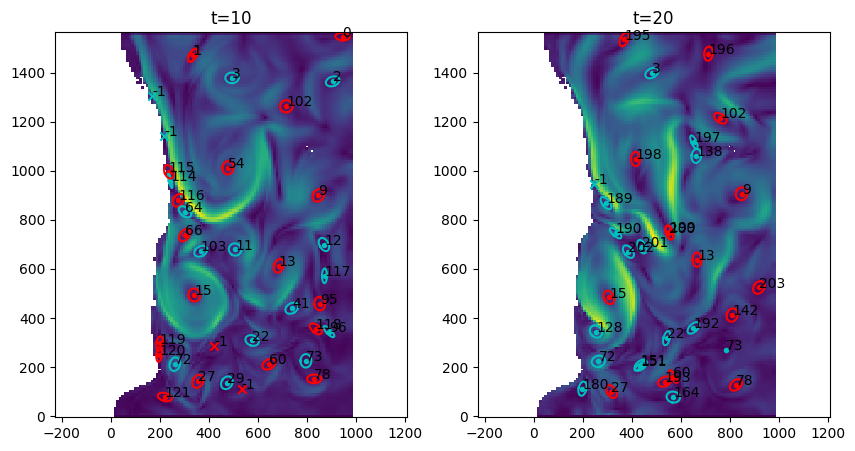

In [13]:
t = 10

fig, axs = plt.subplots(1, 2, figsize=(10,5))

for p, t in enumerate([t, t+10]):

    day = list(ROMS_velocity_dic.keys())[t]
    u0, v0 = ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v']

    
    spacing = 10
    axs[p].pcolor(X_new[::spacing, ::spacing], Y_new[::spacing, ::spacing], np.hypot(u0[::spacing, ::spacing], v0[::spacing, ::spacing]))
    
    df_day = df_data[df_data['Day']==day].copy()
    
    for e in df_day['Eddy'].unique():
        flag = 0
    
        df_eddy = df_day[df_day['Eddy']==e].copy()
    
        x0, y0, q11, q12, q22 = df_eddy['x0'].iloc[0], df_eddy['y0'].iloc[0], df_eddy['q11'].iloc[0], df_eddy['q12'].iloc[0], df_eddy['q22'].iloc[0]
    
        if np.isnan(x0):
            x0, y0 = df_eddy['nxc'].iloc[0], df_eddy['nyc'].iloc[0]
            flag = 1
        
        c = 'r' if df_eddy['Cyc'].iloc[0] == 'AE' else 'c'
        marker = 'x' if flag else '.'
        axs[p].scatter(x0, y0, color=c, marker=marker)
    
        Q = np.array([[q11, q12], [q12, q22]])
        x_ellipse, y_ellipse = plot_ellipse(Q, (x0, y0), scale=30)
        axs[p].plot(x_ellipse, y_ellipse, color=c)
    
        ID = df_eddy['ID'].iloc[0]
        axs[p].text(x0, y0, ID)

    axs[p].set_title(f't={t}')
    axs[p].axis('equal')

In [14]:
df_eddies = df_data[df_data['ID']>=0].copy()
col_to_move = 'ID'
new_order = [col_to_move] + [col for col in df_eddies.columns if col != col_to_move]
df_eddies = df_eddies[new_order]
df_eddies = df_eddies.sort_values(by=['ID', 'Day']).drop('Eddy', axis=1)
df_eddies = df_eddies[df_eddies.groupby('ID')['ID'].transform('count') >= 21]
df_eddies['ID'] = df_eddies['ID'].rank(method='dense').astype(int)
df_eddies

,ID,Day,Cyc,nLon,nLat,nxc,nyc,nic,njc,x0,y0,q11,q12,q22,w
2,1,1462,CE,161.070068,-29.736625,928.0,1356.0,928,1356,929.532120,1359.081341,-0.002460,0.001192,-0.003187,-0.011293
43,1,1463,CE,160.817916,-29.751246,905.0,1346.0,905,1346,910.409810,1346.368459,-0.006279,0.001039,-0.002655,-0.017868
84,1,1464,CE,160.891777,-29.755719,912.0,1348.0,912,1348,915.918179,1345.231552,-0.003853,0.000654,-0.002549,-0.012804
122,1,1465,CE,160.926573,-29.615816,911.0,1364.0,911,1364,914.513286,1361.918280,-0.004816,0.001225,-0.003001,-0.015635
155,1,1466,CE,160.902923,-29.589467,908.0,1366.0,908,1366,909.171353,1361.201101,-0.003874,0.001326,-0.003299,-0.014347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5632,51,1608,AE,156.657106,-36.619098,738.0,484.0,738,484,735.155830,482.224638,0.003418,-0.001327,0.005769,0.018374
5679,51,1609,AE,156.696364,-36.640006,742.0,483.0,742,483,743.644933,482.803186,0.003285,-0.001798,0.005390,0.017348
5724,51,1610,AE,156.733937,-36.632097,745.0,485.0,745,485,748.297426,487.608660,0.003595,-0.002031,0.004684,0.016557
5777,51,1611,AE,156.753345,-36.609445,746.0,488.0,746,488,747.360730,490.106867,0.003598,-0.001749,0.004335,0.015866


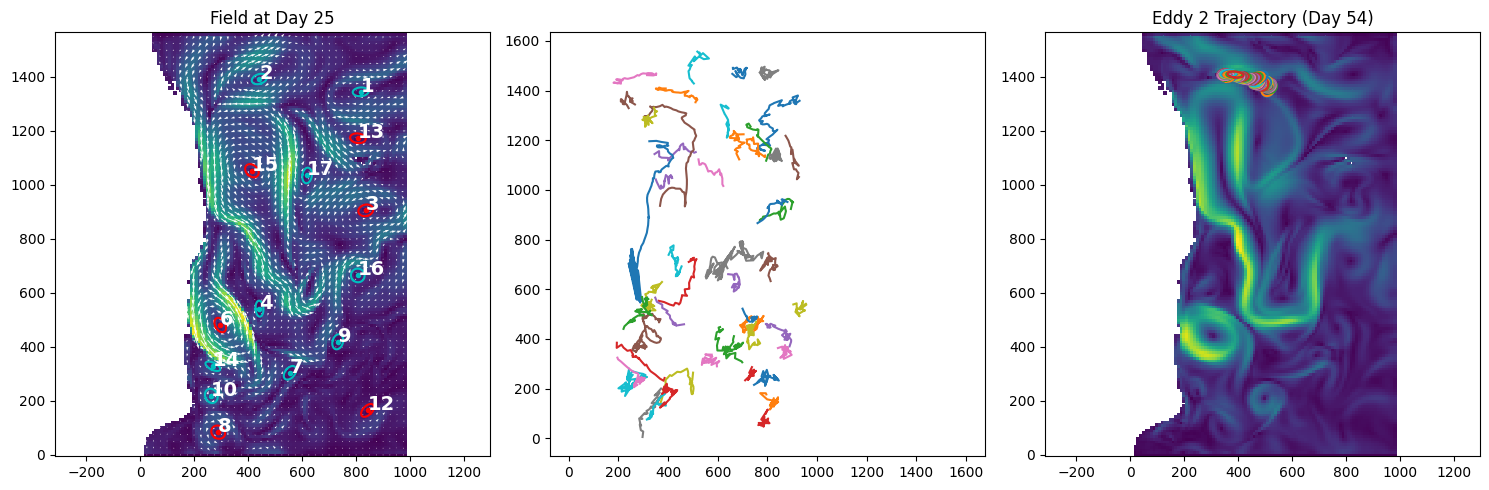

In [15]:
t = 25
eddy = 2

# Create a figure with 1 row and 2 columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# -----------------------------
# Plot 1: Data for Day t = 29
# -----------------------------
day = list(ROMS_velocity_dic.keys())[t]
u0, v0 = ROMS_velocity_dic[day]['u'], ROMS_velocity_dic[day]['v']
spacing = 10
# Plot the pcolor on the first subplot
ax1.pcolor(X_new[::spacing, ::spacing], 
           Y_new[::spacing, ::spacing], 
           np.hypot(u0[::spacing, ::spacing], v0[::spacing, ::spacing]))

spacing_quiv = 25
ax1.quiver(X_new[::spacing_quiv, ::spacing_quiv], 
           Y_new[::spacing_quiv, ::spacing_quiv], 
           u0[::spacing_quiv, ::spacing_quiv], v0[::spacing_quiv, ::spacing_quiv], color='w', width=.002, scale=50)

df_day = df_eddies[df_eddies['Day'] ==day].copy()

for e in df_day['ID'].unique():
    flag = 0
    df_eddy = df_day[df_day['ID'] == e].copy()

    # Get initial values
    x0 = df_eddy['x0'].iloc[0]
    y0 = df_eddy['y0'].iloc[0]
    q11 = df_eddy['q11'].iloc[0]
    q12 = df_eddy['q12'].iloc[0]
    q22 = df_eddy['q22'].iloc[0]

    # Check for NaNs and use alternative coordinates if needed
    if np.isnan(x0):
        x0 = df_eddy['nxc'].iloc[0]
        y0 = df_eddy['nyc'].iloc[0]
        flag = 1
    
    # Set color based on 'Cyc' column
    c = 'r' if df_eddy['Cyc'].iloc[0] == 'AE' else 'c'
    marker = 'x' if flag else '.'
    
    # Plot the point, ellipse and text on the first subplot
    ax1.scatter(x0, y0, color=c, marker=marker)
    Q = np.array([[q11, q12], [q12, q22]])
    x_ellipse, y_ellipse = plot_ellipse(Q, (x0, y0), scale=30)
    ax1.plot(x_ellipse, y_ellipse, color=c)
    ID = df_eddy['ID'].iloc[0]
    ax1.text(x0, y0, ID, color='w', fontsize=14, fontweight='bold')

ax1.axis('equal')
ax1.set_title(f'Field at Day {t}')

# -----------------------------
# Plot 3: Trace for Eddy = {eddy}
# -----------------------------

for e in df_eddies['ID'].unique():
    df = df_eddies[df_eddies['ID']==e]
    ax2.plot(df['x0'], df['y0'], label=e)
# ax2.legend(ncol=2)
ax2.axis('equal')
ax2.set_xlim(0, 1600)


# -----------------------------
# Plot 3: Trace for Eddy = {eddy}
# -----------------------------
df_eddy6 = df_eddies[df_eddies['ID'] == eddy].copy()
d_plot = df_eddy6['Day'].max()

u0, v0 = ROMS_velocity_dic[d_plot]['u'], ROMS_velocity_dic[d_plot]['v']

# Plot the pcolor on the second subplot
ax3.pcolor(X_new[::spacing, ::spacing], 
           Y_new[::spacing, ::spacing], 
           np.hypot(u0[::spacing, ::spacing], v0[::spacing, ::spacing]))

# Plot the trajectory/ellipse for each time step
for t_ind, t_val in enumerate(df_eddy6['Day']):
    x0 = df_eddy6['x0'].iloc[t_ind]
    y0 = df_eddy6['y0'].iloc[t_ind]
    q11 = df_eddy6['q11'].iloc[t_ind]
    q12 = df_eddy6['q12'].iloc[t_ind]
    q22 = df_eddy6['q22'].iloc[t_ind]
    
    ax3.scatter(x0, y0, marker='.')
    Q = np.array([[q11, q12], [q12, q22]])
    x_ellipse, y_ellipse = plot_ellipse(Q, (x0, y0), scale=30)
    ax3.plot(x_ellipse, y_ellipse)

ax3.axis('equal')
ax3.set_title(f'Eddy {eddy} Trajectory (Day {d_plot-1461})')

plt.tight_layout()
plt.show()
